## Estimation Example



In this document we&rsquo;ll work through a simple approach to estimating
Constant Frisch Elasticity (CFE) demand systems.

There are two prerequisites; the first is the `CFEDemands` python
module.  You may have this already, but if not it  can be installed with a simple:



In [11]:
!pip install -r requirements.txt

The second prerequisite is a dataset including detailed information on
household expenditures and characteristics.  The structure of that
dataset is detailed in the next section.



### Data



Consider the case in which the data are saved in a google sheet; we&rsquo;ll
turn data from these into `pandas` dataframes.
There are limits on the allowable size of google sheets (5 million
cells when I last checked), so if your dataset is larger than this you&rsquo;ll need some other
mechanism to get your data into such dataframes.  Even in this latter
case you&rsquo;ll want your dataframes to have a structure that matches the
description given below.



#### Structure of the Spreadsheet



An example spreadsheet with data for Uganda can be found at
[https://docs.google.com/spreadsheets/d/1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w/](https://docs.google.com/spreadsheets/d/1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w/)

This spreadsheet consists of several worksheets, labeled &ldquo;RDI&rdquo;, &ldquo;FCT&rdquo;,
&ldquo;Household Characteristics&rdquo;, and a series of different years of food expenditures and prices

Most worksheets have the initial three columns labeled &ldquo;i&rdquo;, &ldquo;t&rdquo;, and
&ldquo;m&rdquo;; together these identify an observation uniquely.  The column &ldquo;i&rdquo;
should include a household id; the column &ldquo;t&rdquo; should include an
indicator for the year or period (for those of you with
cross-sectional data these will all take a common value, e.g., 2019);
the column &ldquo;m&rdquo; should be an indicator of &ldquo;market&rdquo;, which may be a
region identifier, or may take a single value (e.g., &ldquo;Uganda&rdquo;).

The triple (i,t,m) will serve as the index of some constructed
dataframes.  It is important not to have **too** many different values
for &ldquo;m&rdquo; (unless you have lots of data and RAM to play with).

Beyond the first three columns, the &ldquo;Expenditures&rdquo; worksheet for a given year should have one index (or alternatively, one column) for each category of expenditures (e.g., &ldquo;Beans&rdquo;, &ldquo;Beef&rdquo;, &ldquo;Beer&rdquo;,&#x2026;).

Beyond the first three columns, the &ldquo;Household Characteristics&rdquo; should
have columns corresponding to different elements of the vector of
observable characteristics $z$.  If the data permit, I recommend
constructing observables that match what I have in these data:
namely numbers of different children by age and sex, along with the
logarithm of total household size (&ldquo;log HSize&rdquo;).



#### From Sheet to DataFrame to Regression Object



We begin by defining a dictionary that contains the spreadsheet key.
One is provided for the Ugandan example that I wish to work
through.



In [12]:
#Uganda_Data = '1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w'
Senegal_Data = '1FrCW6vIbpHx9jDfo2tBugmkUn5XoO-j5vE2Z5dLgU0E'

With the spreadsheet defined , grab it and define a couple of
dataframes. (Sheets should be shared with `students@eep153.iam.gserviceaccount.com`):



In [13]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

# === 1. Food Expenditures ===
#x = read_sheets(Senegal_Data, sheet='Food Expenditures (2019)')
x = pd.read_csv("Food_Expenditures_T(2019).csv", header= 0, index_col=0)
x = x.set_index(['i', 't', 'm', 'j']).squeeze()

# === 2. Food Prices ===
#p = read_sheets(Senegal_Data, sheet='Food Prices (2019)').set_index(['t', 'm', 'j', 'u'])
p = pd.read_csv('Food_Prices_T(2019).csv', header= 0).set_index(['t', 'm', 'j', 'u'])
p = p.drop(columns=["Unnamed: 0", "Unnamed: 0.1"])

# Compute medians of prices for each (t, m, j, u)
p = p.groupby(['t', 'm', 'j', 'u']).median()

# Keep only Kg unit
p = p.xs('Kg', level="u").squeeze().unstack('j')

# Find intersection of goods between price data and expenditure data
common_goods = list(set(p.columns).intersection(set(x.index.get_level_values('j'))))

# Filter both datasets to those goods
p = p[common_goods].T

# === 3. Household Characteristics ===
#d = read_sheets(Senegal_Data, sheet='Household Characteristics')
d = pd.read_csv('Household_Characteristics.csv', header= 0)
d.columns.name = 'k'

# Replace blanks with zeros
d = d.replace(np.nan, 0)

# Group expenditures and clean
x = x.T.groupby(['i', 't', 'm', 'j']).sum()
x = x.replace(0, np.nan)

# Take logs of expenditures
y = np.log(x)

# Set index for household characteristics
d.set_index(['i', 't', 'm'], inplace=True)
d = d.drop(columns=["Unnamed: 0"])

This gives a dataframe of household characteristics $d$ with a simple structure.



In [14]:
d.head()

,,k,women,girls,boys,men,Males 00-03,Females 00-03,Males 04-08,Females 04-08,Males 09-13,Females 09-13,Males 14-18,Females 14-18,Males 19-30,Females 19-30,Males 31-50,Females 31-50,Males 51-99,Females 51-99,log HSize
i,t,m,,,,,,,,,,,,,,,,,,,
11011,2018,ziguinchor,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000000
110110,2018,ziguinchor,1,1,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1.386294
110111,2018,ziguinchor,0,0,2,2,0,0,0,0,0,0,2,0,1,0,1,0,0,0,1.386294
110112,2018,ziguinchor,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0.693147
11012,2018,ziguinchor,2,4,2,2,0,0,0,1,1,1,1,2,1,1,0,1,1,0,2.302585


Also a dataframe of log expenditures $y$ with a similarly simple
structure.  Note that any expenditures of zero are dropped and
replaced with a missing value indicator.



In [15]:
y.head()

i    t     m      j                           
221  2019  dakar  Beef                            8.006368
                  Cabbage                         4.605170
                  Caramel, candy, sweets, etc.    5.703782
                  Carrot                          4.605170
                  Cassava                         4.605170
Name: Expenditure, dtype: float64

### Estimation



Let $y_{i}^j$ be log expenditures on food $j$ by household $i$ at a particular time.  We want to estimate a regression that takes the form
$$
      y^j_{i} = A^j(p) + \gamma_j'd_i + \beta_j w_i + \zeta^j_i.
$$
We have data on `y` (log expenditures) and `d` (household characteristics).  This leaves the rest of the elements for us to estimate.



#### Basic Estimation



Just one line to set up the regression:



In [16]:
from cfe import Regression

result = Regression(y=y,d=d)

And then one line to predict expenditures and estimate most of the things we need:



In [ ]:
result.predicted_expenditures()

Now we can compare predicted log expenditures with actual:



In [ ]:
%matplotlib inline
df = pd.DataFrame({'y':y,'yhat':result.get_predicted_log_expenditures()})
df.plot.scatter(x='yhat',y='y')
df

That&rsquo;s all there is to estimation!  Note that we didn&rsquo;t estimate
demands for all goods&#x2014;lots of goods didn&rsquo;t have enough observations,
and were automatically dropped.



#### Parameters



##### (Relative) Income Elasticity



Some of the parameters have an interesting interpretation.  First among these are the $\beta$ coefficients, which govern how *income elastic* different goods are (higher values means more elastic).  These are also called *Frisch elasticities*.
Here we use a plot to visualize, with confidence intervals.



In [ ]:
ax = result.graph_beta()

To just see the values of $\beta$:



In [ ]:
result.get_beta()

##### Demand and Household Composition



We&rsquo;re particularly interested in the effects of household composition on demand.  These are captured by the $\gamma_j$ parameters in the regression.



In [ ]:
result.get_gamma()

##### Welfare



Another import quantity we estimate is $w_i$.  This is a welfare measure for the household.  Here&rsquo;s a histogram:



In [ ]:
ax = result.get_w().plot.hist(bins=100,density=True)
result.get_w().plot.kde(ax=ax)

#### Saving Result



You can save the estimated result, using something like



In [ ]:
# Save the regression result
result.to_pickle('senegal_estimates.rgsn')

You can subsequently load this using



In [ ]:
import cfe
result = cfe.regression.read_pickle('senegal_estimates.rgsn')

#### Demand and Utility



Having estimated the demand system, we can examine the implied demand curves.



##### Budgets



Get food budget for all households, then find median budget:



In [ ]:
import numpy as np

# Get predicted expenditures
xhat = result.predicted_expenditures()

# Total food expenditures per household (i, t, m)
xbar = xhat.groupby(['i', 't', 'm']).sum()

# Reference budget: median household's budget
xref = xbar.quantile(0.5)  # 50th percentile

##### Reference Prices



Choose reference prices.  Here we&rsquo;ll choose a particular year, and average prices across markets.  If you wanted to focus on particular market you&rsquo;d do this differently.



In [ ]:
# Step 1: Average prices across markets
pbar = p.mean(axis=1)  # average over markets (axis=1)

# Step 2: Keep only goods that exist in both price data and estimated betas
estimated_goods = result.beta.index             # goods estimated by the model
available_goods = pbar.index                    # goods for which we have price data
common_goods = estimated_goods.intersection(available_goods)  # safe intersection
pbar = pbar.loc[common_goods]

# Step 3: Replace any missing values with 1 (for stability in simulations)
pbar = pbar.replace(np.nan, 1)

def my_prices(p0, j, p=pbar):
    """
    Change price of j-th good to p0, holding other prices fixed.
    
    Parameters:
    p0: new price to set
    j:  name of the good (string)
    p:  reference price vector (default: pbar)
    """
    p = p.copy()
    p.loc[j] = p0
    return p

##### Demand as a function of prices



Let&rsquo;s take a look at demand schedules for households with different budgets.



In [ ]:
pbar.head()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#Step 1: Get average price per good from the data
pbar_full = p.mean(axis=1)  # Average across markets

#Step 2: Reindex to match the order of goods used in the regression model
goods = result.beta.index  # This is the correct good order expected by the model
pbar = pbar_full.reindex(goods)  # Align price vector to match model order

#Step 3: Fill any missing prices with 1 (to avoid errors)
pbar = pbar.fillna(1)

#Step 4: Choose a good from the list (make sure it's in result.beta.index)
print("Available goods:", list(pbar.index))
use = 'Beef'  # Replace with another valid good if needed

#Step 5: Define a safe price-change function
def my_prices(p0, j, p=pbar):
    p = p.copy()
    p.loc[j] = p0
    return p

#Step 6: Plot demand curve
scale = np.linspace(0.5, 2, 20)

#Demand at median budget
plt.plot(
    [result.demands(xref, my_prices(pbar[use] * s, use))[use] for s in scale],
    scale,
    label='Median HH'
)

#25th percentile budget
plt.plot(
    [result.demands(xbar.quantile(0.25), my_prices(pbar[use] * s, use))[use] for s in scale],
    scale,
    label='25th %ile HH'
)

#75th percentile budget
plt.plot(
    [result.demands(xbar.quantile(0.75), my_prices(pbar[use] * s, use))[use] for s in scale],
    scale,
    label='75th %ile HH'
)

#Step 7: Final plot formatting
plt.xlabel(f"Quantities of {use} Demanded")
plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.title(f"Demand Curve for {use}")
plt.legend()
plt.grid(True)
plt.show()

##### Engel Curves



Engel curves trace out how demand changes with budget:



In [ ]:
# Step 1: Normalize reference prices so their average is 1
pbar_normalized = pbar / pbar.mean()

# Step 2: Recalculate Engel curves with normalized pbar
fig, ax = plt.subplots()

ax.plot(
    np.log(scale * xref),
    [result.expenditures(s * xref, pbar_normalized) / (s * xref) for s in scale]
)

ax.set_xlabel(f"log budget (relative to base of {xref:.0f})")
ax.set_ylabel("Expenditure share")
ax.set_title("Engel Curves (Normalized Prices)")

plt.show()

In [ ]:
# Expenditure shares at base budget
shares = result.expenditures(xref, pbar) / xref
shares.sort_values(ascending=False).head(10)

Engel Curve of Top 5 Non-Dominant Goods (exclude Huile de soja / végétale):

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import consumerdemands._core as core

# Loosen solver tolerance to avoid convergence issues
core.default_solver_tolerance = 1e-8

# Step 1: Define scale
scale = np.linspace(0.5, 2, 20)

# Step 2: Calculate expenditure shares
shares = result.expenditures(xref, pbar) / xref
dominant_good = shares.sort_values(ascending=False).index[0]
top_goods = shares.drop(dominant_good).sort_values(ascending=False).head(5).index

# Step 3: Compute Engel curves using full price vector
fig, ax = plt.subplots()

for g in top_goods:
    share_curve = []
    for s in scale:
        try:
            demands = result.demands(s * xref, pbar)
            share = demands[g] * pbar[g] / (s * xref)
            share_curve.append(share)
        except Exception as e:
            print(f"Skipped {g} at scale {s} due to error: {e}")
            share_curve.append(np.nan)
    
    ax.plot(np.log(scale * xref), share_curve, label=g)

# Step 4: Plot formatting
ax.set_xlabel(f"log budget (relative to base of {xref:.0f})")
ax.set_ylabel("Expenditure share")
ax.set_title("Engel Curves (Top 5 Non-Dominant Goods)")
ax.legend()
plt.show()

In [ ]:
# Step 1: Compute expenditure shares at base budget
shares = result.expenditures(xref, pbar) / xref

# Step 2: Drop dominant good (the one with the highest share)
shares_no_dominant = shares.sort_values(ascending=False).iloc[1:]
goods_to_plot = shares_no_dominant.index

# Step 3: Budget scaling range
scale = np.linspace(0.5, 2, 20)

# Step 4: Plot Engel curves
fig, ax = plt.subplots(figsize=(12, 7))

for g in goods_to_plot:
    share_curve = [
        result.demands(s * xref, pbar)[g] * pbar[g] / (s * xref)
        for s in scale
    ]
    ax.plot(np.log(scale * xref), share_curve, label=g)

# Step 5: Labels, legend, formatting
ax.set_xlabel(f"log budget (relative to base of {xref:.0f})")
ax.set_ylabel("Expenditure share")
ax.set_title("Engel Curves (All Goods Except Dominant)")
ax.legend(fontsize=6, loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=2)
plt.tight_layout()
plt.show()

##### Indirect Utility



We can also describe an indirect utility function that corresponds to these demands:



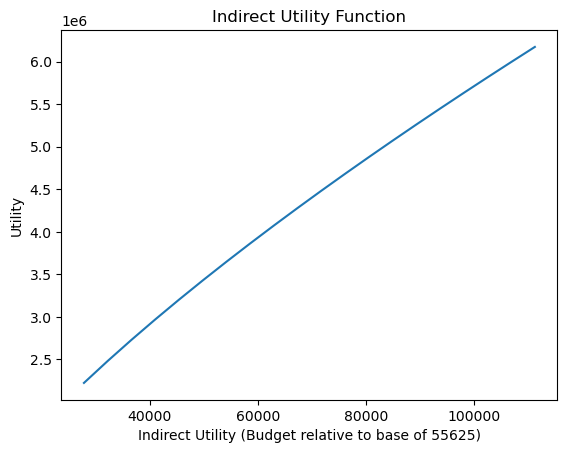

In [142]:
# Plot the indirect utility function over scaled budgets
fig, ax = plt.subplots()

# Compute utility values for different scaled budgets
utilities = [result.indirect_utility(s * xref, pbar) for s in scale]

# Plot
ax.plot(scale * xref, utilities)
ax.set_xlabel(f"Indirect Utility (Budget relative to base of {xref:.0f})")
ax.set_ylabel("Utility")
ax.set_title("Indirect Utility Function")
plt.show()